In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import loadmat

#set plotting style 
plt.style.use('ggplot')

import sys
import os
import copy
from google.colab import drive
drive.mount('/content/gdrive',force_remount='True')

rawdata = loadmat('/content/gdrive/My Drive/Colab Notebooks/KS.mat')

Mounted at /content/gdrive


In [3]:
t = rawdata['tt']
x=rawdata['x']
uu=rawdata['uu']
uu.size

103113

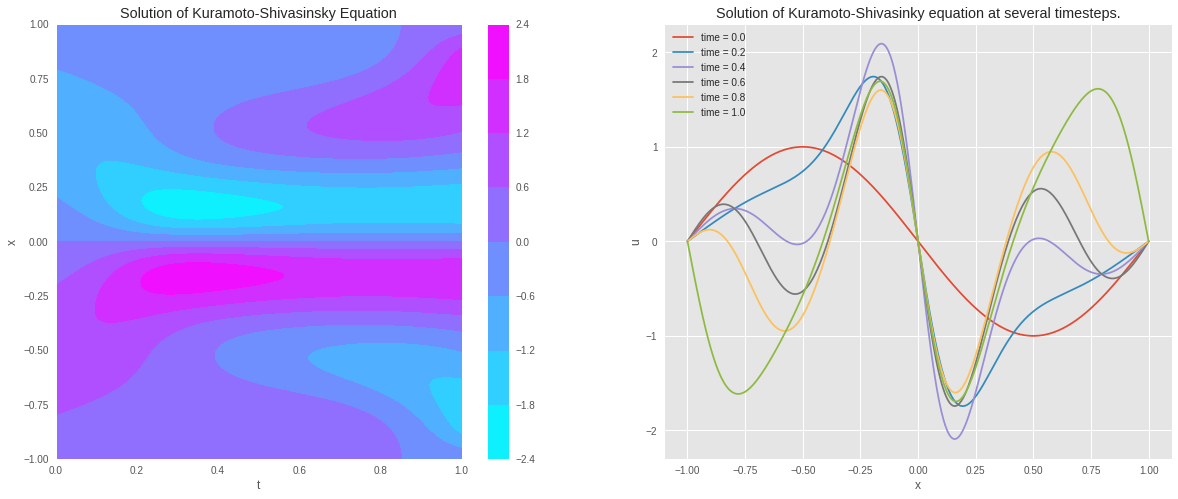

In [5]:
x_grid,t_grid = np.meshgrid(x,t,indexing='ij')

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.contourf(t_grid,x_grid,uu,cmap='cool')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution of Kuramoto-Shivasinsky Equation')
plt.colorbar()

plt.subplot(122)
for time in np.arange(0, np.shape(uu)[1], 40):
    plt.plot(np.transpose(x), uu[:, time], label='time = %.1f'%t[0,time])
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Solution of Kuramoto-Shivasinky equation at several timesteps.')
plt.show()

In [ ]:
X = np.transpose((x_grid.flatten(), t_grid.flatten()))
y_truth = uu.reshape((uu.size, 1))

In [ ]:
noise = 0
y = y_truth * (1 + noise * np.random.normal(size=(y_truth.size, 1)))

In [8]:
idx = np.random.permutation(y.size)
split = [int(0.2 * y.size)]

X_train, X_test = np.vsplit(X[idx, :], split)
y_train, y_test = np.vsplit(y[idx, :], split)
y_train.size

25778

In [ ]:
def NN_L1(config, library_function, library_config):
    '''
    Constructs physics informed neural network with L1 regularisation graph.
    Note: assumes space is the first column, time the second in data.
    '''
    tf.reset_default_graph()
    # Creating datasets
    data_feed = tf.placeholder(tf.float32, shape=[None, config['layers'][0]])
    target_feed = tf.placeholder(tf.float32, shape=[None, config['layers'][-1]])
    mask_feed = tf.placeholder(tf.int32, shape=[None, 1])

    lambda_L1 = tf.constant(config['lambda'], tf.float32)

    coeffs = tf.Variable(config['initial_coeffs'], dtype=tf.float32)

    mask = tf.ones([tf.size(target_feed[:, 0:1]), tf.size(mask_feed)], dtype=tf.int32)*tf.transpose(mask_feed)
    dataset = tf.data.Dataset.from_tensor_slices((data_feed, target_feed, mask)).repeat().batch(tf.shape(data_feed, out_type=tf.int64)[0])

    iterator = dataset.make_initializable_iterator()
    data, target, sparsity_mask = iterator.get_next()

    # The actual network
    X = data
    for idx, layer in enumerate(np.arange(len(config['layers'])-2)):
        X = tf.layers.dense(X, units=config['layers'][layer+1], activation=tf.nn.tanh, kernel_initializer=tf.constant_initializer(config['initial_weights'][idx]), bias_initializer=tf.constant_initializer(config['initial_biases'][idx]))
    prediction = tf.layers.dense(inputs=X, units=config['layers'][-1], activation=None, kernel_initializer=tf.constant_initializer(config['initial_weights'][-1]), bias_initializer=tf.constant_initializer(config['initial_biases'][-1]))

    # make library according to supplied function
    y_t, theta = library_function(data, prediction, library_config)

    theta_split = tf.dynamic_partition(theta, sparsity_mask, 2)
    theta_sparse = tf.reshape(theta_split[1], [tf.shape(theta)[0], tf.shape(coeffs)[0]])

    # Normalizing
    scaling_theta = tf.expand_dims(tf.norm(theta_sparse, axis=0), axis=0)
    scaling_time = tf.norm(y_t)

    coeffs_scaled = coeffs * tf.transpose(scaling_theta/scaling_time) # unscaled coefficients
    # Defining cost function
    f = tf.matmul(theta_sparse, coeffs) - y_t

    cost_MSE = tf.reduce_mean(tf.square(target - prediction))
    cost_PI = tf.reduce_mean(tf.square(f))
    cost_L1 = lambda_L1*tf.reduce_sum(tf.abs(coeffs_scaled))

    loss = cost_MSE + cost_PI + cost_L1
    # graph node for gradient
    gradloss = tf.reduce_max(tf.abs(tf.gradients(loss, coeffs)[0]*scaling_time/scaling_theta))

    return AttrDict(locals())


class AttrDict(dict):
    __getattr__ = dict.__getitem__
__setattr__ = dict.__setitem__

In [ ]:
def sparse_PINN(data, target, config, library_function, library_config, train_opts):
    '''
    sparse_NN returns a sparse weights vector as determined by a PINN with L1-regularization.
    '''
    def run_sparse(library_function, library_config, train_opts):
        graph = NN_L1(sparse_config, library_function, library_config)
        # Defining optimizer
        train_op = tf.train.AdamOptimizer(learning_rate=train_opts['learning_rate'], beta1=train_opts['beta1'], beta2=train_opts['beta2'], epsilon=train_opts['epsilon']).minimize(graph.loss)

        feed_dict = {graph.data_feed: data, graph.target_feed: target, graph.mask_feed: mask}

        # Running the fitting procedure
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer(), feed_dict=feed_dict)
            sess.run(graph.iterator.initializer, feed_dict=feed_dict)
            print('Now minimizing...')
            print('Total loss | Gradient loss | MSE | PI | L1 ')
            for i in np.arange(train_opts['max_iterations']):
                sess.run(train_op)
                if i % 500 == 0:
                    print(i, sess.run([graph.loss, graph.gradloss, graph.cost_MSE, graph.cost_PI, graph.cost_L1]))
                    if np.abs(sess.run(graph.gradloss)) < train_opts['grad_tol']:
                        print('Adam converged.')
                        break
                if i == train_opts['max_iterations']-1:
                    print('Reached maximum iterations. Check convergence!')

            w_scaled = map_to_coeff_vector(mask, sess.run(graph.coeffs_scaled))
            w = map_to_coeff_vector(mask, sess.run(graph.coeffs))  #unscaled vector
            weights_biases = sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))[1:]
            weights = weights_biases[::2]
            biases = weights_biases[1::2]
        return w, w_scaled, weights, biases

    # Define sparse config
    sparse_config = copy.deepcopy(config)

    initial_coeffs = np.random.rand(library_config['total_terms'], 1) * 2 - 1
    initial_biases = []
    initial_weights = []

    for layer in np.arange(1, len(config['layers'])):
        initial_biases.append(np.zeros(config['layers'][layer]))
        initial_weights.append(np.random.randn(config['layers'][layer-1], config['layers'][layer])*np.sqrt(1/(config['layers'][layer-1]+config['layers'][layer]))) #Xavier initialization

    mask = np.ones((library_config['total_terms'], 1))
    sparse_config.update({'initial_coeffs': initial_coeffs, 'initial_weights': initial_weights, 'initial_biases':initial_biases})

    # Run minimization procedure
    while True:
        w, w_scaled, weights, biases = run_sparse(library_function, library_config, train_opts)
        if sparse_config['threshold'] == 'auto':
            upper_lim, lower_lim = np.median(w_scaled)+np.std(w_scaled), np.median(w_scaled) - np.std(w_scaled)
            print('Setting all elements between %.3f and %.3f to zero.' % (upper_lim, lower_lim))
            sparsity_mask = (w_scaled <= upper_lim) & (w_scaled >= lower_lim)
        else:
            sparsity_mask = np.abs(w_scaled) < sparse_config['threshold']

        w[sparsity_mask] = 0
        coeffs = np.expand_dims(w[w != 0], axis=1)
        sparse_config.update({'initial_coeffs': coeffs,'initial_weights': weights, 'initial_biases':biases})

        # If a term gets taken off, its not converged:
        if np.count_nonzero(w) != np.count_nonzero(mask):
            mask[w == 0] = 0
            sparse_config['non_zero_terms'] = np.count_nonzero(mask[:, 0])
            print('Current sparse vector:')
            print(w)
        else:
            break

    # Now thats it's converged, fit again but without the L1 penalty

    print('Running for the final time...')
    sparse_config['lambda'] = 0
    sparse_config['threshold'] = 0
    train_opts['grad_tol'] = train_opts['grad_tol']/10 # for the final run we want better estimates
    w, _, _, _ = run_sparse(library_function, library_config, train_opts)

    return w


In [ ]:
def library_1D(data, prediction, library_config):
    '''
    Constructs a library graph in 1D. Library config is dictionary with required terms.
    '''

    # Polynomial
    u = tf.ones_like(prediction)

    for order in np.arange(1, library_config['poly_order']+1):
        u = tf.concat((u, u[:, order-1:order]*prediction), axis=1)
    u = tf.expand_dims(u, axis=2)

    # Gradients
    dy = tf.gradients(prediction, data)[0]
    y_t = dy[:, 1:2]
    y_x = dy[:, 0:1]

    du = tf.concat((tf.ones_like(y_x), y_x), axis=1)
    for order in np.arange(2, library_config['deriv_order']+1):
        du = tf.concat((du, tf.gradients(du[:, order-1], data)[0][:, 0:1]), axis=1)
    du = tf.expand_dims(du, axis=1)

    # Bringing it together
    theta = tf.matmul(u, du)
    theta = tf.reshape(theta, [tf.shape(theta)[0], tf.size(theta[0, :, :])])

    return y_t, theta

In [ ]:
def map_to_coeff_vector(mask, coeffs):
    '''
    Maps coefficent vector back to vector with size of mask.
    '''
    coeffs_vector = np.copy(coeffs)
    w = np.zeros_like(mask, dtype=np.float)
    for idx in np.arange(w.shape[0]):
        if mask[idx, 0] == 1:
            w[idx, 0] = coeffs_vector[0, 0]
            coeffs_vector = coeffs_vector[1:, :]
    return w

In [ ]:
def library_matrix_mat(u, v, latex=False):
    '''
    Implements the matrix multiplication for strings and flattens it, mimicing how the library is made.
    Set latex=True to obtain latex forms.
    '''
    comp_list=[]
    for u_element in u:
        for v_element in v:
            if ((u_element == '1') and ('v_element' == '1')):
                result = '1'
            elif u_element == '1':
                result = v_element
            elif v_element == '1':
                 result = u_element
            else:
                result = u_element + v_element
            comp_list.append(result)
    if latex is True:
        comp_list = list(map(lambda x: '$'+x+'$', comp_list))
    return comp_list

In [ ]:
def print_PDE(sparse_vector, coeffs_list, PDE_term='u_t'):
    '''
    Prints PDE with non-zero components according to sparse_vector.
    Set PDE_term to different string for different equations.
    '''
    non_zero_idx = np.nonzero(sparse_vector)[0]
    PDE = PDE_term + ' = '
    for idx, term in enumerate(non_zero_idx):
        if idx !=0:
            if np.sign(sparse_vector[term])==-1:
                PDE += ' - '
            else:
                PDE += ' + '
        PDE += '%.3f'%np.abs(sparse_vector[term]) + coeffs_list[term]
    print(PDE)

In [ ]:
noise = 0.00
HL = [2,30,30,30,30,30,30,30, 1]
l1 = 10**-6

In [16]:
config = {'layers': HL, 'lambda': l1, 'threshold': 'auto'}
library_config = {'total_terms': 10, 'deriv_order': 4, 'poly_order': 1}
train_opts = {'learning_rate': 0.002, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8, 'max_iterations': 20000, 'grad_tol':10**-7}

sparse_vector = sparse_PINN(X_train, y_train, config, library_1D, library_config, train_opts)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Now minimizing...
Total loss | Gradient loss | MSE | PI | L1 


KeyboardInterrupt: ignored

In [ ]:
u = ['1', 'u']
du = ['1', 'u_{x}', 'u_{xx}','u_{xxx}','u_{xxxx}']

coeffs_list = library_matrix_mat(u, du)
print('Inferred equation:')
print_PDE(sparse_vector, coeffs_list, PDE_term='u_t')